# Programa de bicicletas compartidas (Bicycle share scheme)


Sistema práctico y al alcance de todos, en donde el usuario puede alquilar fácilmente una bicicleta y/o una bicicleta eléctrica desde cierta posición en particular, los cuales son estacionamientos específicos según la entidad que entrega el servicio, y con la opción de devolverla en otro punto de estacionamiento.

Este sistema toma un papel fundamental en la detección de eventualidades y análisis del comportamiento dentro de una ciudad. Esto debido a que, a diferencia de transportes como buses, metro o automóviles, gracias a los sensores incorporados se puede registrar la información exacta del viaje, como por ejemplo la duración, punto de inicio y punto de llegada.


## Descripción del prolema
Poniéndonos en la situación de que somos parte del equipo de la empresa Rent-Cycle en Wachington DC, y nuestro Team Leader nos da la tarea de implementar un modelo que nos permita **predecir la cantidad de bicicletas que se alquilan** según la información contenida en el dataset puesto a disposición.

**Tipo de problema**: Regresión, ya que la variable objetivo a predecir es un valor numérico

## Procedimiento
1. [Librerías](#id1)
2. [Importación de archivos](#id2)
3. [EDA: Análisis exploratorio de datos](#id3)
    <br>3.1. [Búsqueda de valores faltantes](#id3.1)
    <br>3.2. [Correlación de variables](#id3.2)
    <br>3.3. [Distribuciones](#id3.3)
4. [Feature engineering](#id4)
5. [Pre-procesamiento](#id5)
6. [Modelos de entrenamiento](#id6)
    <br>6.1. [Random Forest](#id6.1)
    <br>6.2. [XGBoost](#id6.2)
    <br>6.3. [Red Neuronal](#id6.3)
7. [Pruebas](#id7)
    <br>7.1. [Random Forest](#id7.1)
    <br>7.2. [XGBoost](#id7.2)
    <br>7.3. [Red Neuronal](#id7.3)



## 1. Librerías
<div id='id1'/>


In [609]:
import math
import statsmodels.api as sm
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

## 2. Importación de archivos
<div id='id2'/>

In [938]:
train_df = pd.read_excel('Dataset/bike_train.xlsx')
test_df = pd.read_excel('Dataset/bike_test_act.xlsx')

In [939]:
train_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [742]:
test_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,12000,2012-05-20,2,1,5,4,0,0,0,1,0.52,0.5000,0.68,0.0896
1,12001,2012-05-20,2,1,5,5,0,0,0,1,0.50,0.4848,0.72,0.1045
2,12002,2012-05-20,2,1,5,6,0,0,0,1,0.50,0.4848,0.63,0.1343
3,12003,2012-05-20,2,1,5,7,0,0,0,1,0.52,0.5000,0.68,0.1940
4,12004,2012-05-20,2,1,5,8,0,0,0,1,0.56,0.5303,0.56,0.1642


## 3. EDA: Análisis exploratorio de datos
<div id='id3'/>

### Búsqueda de valores faltantes
<div id='id3.1'/>

> No presentan valores faltantes ambos datasets

In [612]:
train_df.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [613]:
test_df.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
dtype: int64

### Correlación de variables
<div id='id3.2'/>

Eliminamos la variable `instant` y `dteday`

In [940]:
train_df.drop(labels = ['instant', 'dteday'], axis = 1, inplace = True)

In [744]:
import itertools
from sklearn.metrics import confusion_matrix

def make_correlation(df, figsize = (20,10), text_size = 8):
  
  # Creamos matriz de confusion
    cm = df.corr().values
    n_classes = cm.shape[0]

    fig, ax = plt.subplots(figsize = figsize)
    cax = ax.matshow(cm, cmap = plt.cm.Blues)

    # Establecemos labels para las classes
    labels = df.columns

    # Label the axes
    ax.set(title = "Correlation Matrix",
            xticks = np.arange(n_classes),
            yticks = np.arange(n_classes),
            xticklabels = labels, # axes se etiquetarán con nombres de clase (si existen) o enteros
            yticklabels = labels)
  
    # Establecemos x-axis labels to bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Ajustas tamaño label
    ax.yaxis.label.set_size(text_size)
    ax.xaxis.label.set_size(text_size)
    ax.title.set_size(text_size)
    fig.autofmt_xdate(rotation=70)


    # Establecemos threshold para diferentes colores
    threshold = (cm.max() + cm.min())/2.

    # Dibujamos el texto en cada celda
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{round(cm[i,j], 2)}%",
             horizontalalignment = "center",
             color = "white" if cm[i, j] > threshold else "black",
             size = text_size)

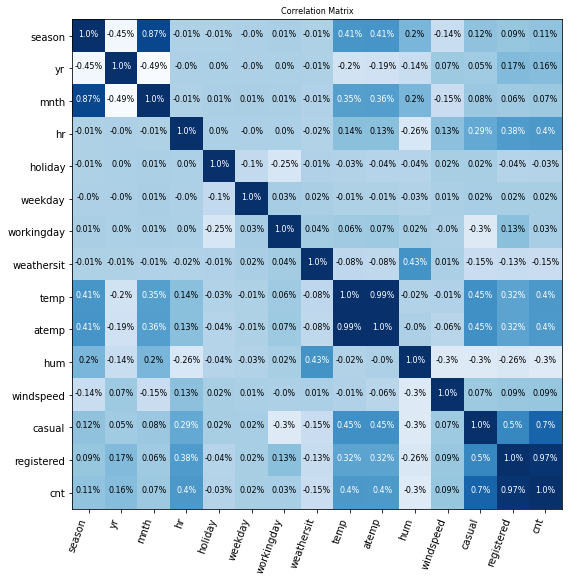

In [745]:
make_correlation(train_df)

<div id='idconc'/>

[Regresar a Feature engineering](#idfeat)

**Conclusiones**:
- Correlación con `cnt`

>`casual`(0.7) y `registered`(0.9) / Cabe resaltar que casual + registered componen la variable cnt, dado que el objetivo a predecir es cnt, se podría trata de 2 maneras:

     - Eliminar cnt, y realizar 2 regresiones (casual y registeres) y luego sumar ambos resultados para obtener la predicción
     
     - Eliminar casual y registered para tener una única variable a predecir

- Correlación entre `season` y `mnth` (0.87)

> Debido a su alta correlación lineal, se decidirá eliminar una de las dos


- Correlación entre `temp` y `atemp` (0.99)

> Debido a su alta correlación lineal, se decidirá eliminar una de las dos

     - Dato a tener en cuenta : En la formula de sensación térmica por frio o calor, atemp recibe como variable independiente a la temperatura
     
- Correlación casi nula con `cnt`

> Se considera un rango entre -0.1 a 0.1

      - `mnth`(0.07), `workingday`(0.03), `weekday`(0.02), `holiday` (-0.03), `windspeed` (0.09)   


In [746]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
season,11999.0,2.210684,1.088798,1.00,1.0000,2.0000,3.0000,4.0000
yr,11999.0,0.279523,0.448784,0.00,0.0000,0.0000,1.0000,1.0000
mnth,11999.0,5.530294,3.433005,1.00,3.0000,5.0000,8.0000,12.0000
hr,11999.0,11.556630,6.911891,0.00,6.0000,12.0000,18.0000,23.0000
holiday,11999.0,0.027752,0.164269,0.00,0.0000,0.0000,0.0000,1.0000
weekday,11999.0,3.009334,2.005264,0.00,1.0000,3.0000,5.0000,6.0000
workingday,11999.0,0.684057,0.464910,0.00,0.0000,1.0000,1.0000,1.0000
weathersit,11999.0,1.435036,0.650894,1.00,1.0000,1.0000,2.0000,4.0000
temp,11999.0,0.465704,0.188576,0.02,0.3200,0.4600,0.6200,0.9600
atemp,11999.0,0.448888,0.169633,0.00,0.3030,0.4545,0.5909,1.0000


### Distribuciones
<div id='id3.3'/>

#### Variable **objetivo**
> Por lo analizado, se encuentra un sesgo positivo, así que existe outliers, el cual veremos que tipo de tratamiento podemos darle, de tal manera no influyan mucho en las predicciones

In [618]:
target = train_df['cnt']

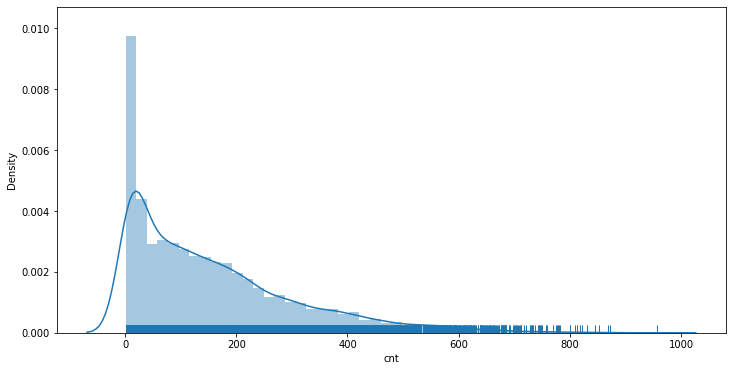

In [747]:
plt.figure(figsize=(12,6))
sns.distplot(train_df['cnt'], rug = True)
plt.show(); 

***Análisis de cuartiles***: Aplicaremos la ley de tukey.

outlier:
- q > Q1 - 1.5*IQR
- q < Q3 + 1.5*IQR

<AxesSubplot:ylabel='cnt'>

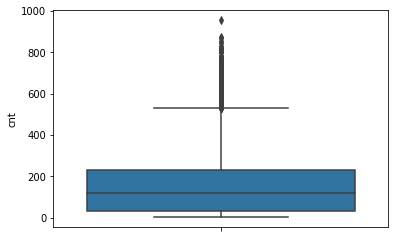

In [620]:
sns.boxplot(y = target)

In [748]:
cuartiles = pd.qcut(target, q = [0,.25,.50,.75,1], retbins = True)[1]
Q1 = cuartiles[1]
Q2 = cuartiles[2]
Q3 = cuartiles[3]
IQR = Q3 - Q1

In [749]:
outl_q = target.apply(lambda e: 1 if (e > Q3 + 1.5*IQR)|(e < Q1 - 1.5*IQR) else 0)

<AxesSubplot:xlabel='cnt', ylabel='count'>

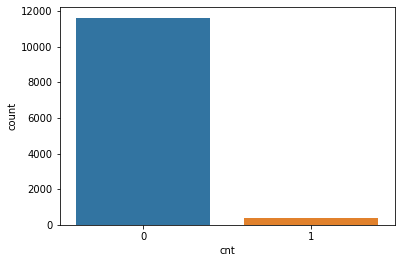

In [750]:
# Cantidad de registros (0: no outliers, 1: outliers)
sns.countplot(outl_q)

In [751]:
outl_q.value_counts()

0    11623
1      376
Name: cnt, dtype: int64

***Análisis de las 3 sigmas***: 
- mínimo = Promedio – 3 * Desviación Estándar
- máximo = Promedio + 3 * Desviación Estándar


In [752]:
std = np.std(target)
mean = np.mean(target)

In [753]:
outl_s = target.apply(lambda e: 1 if (e > mean + 3*std)|(e < mean - 3*std) else 0)

<AxesSubplot:xlabel='cnt', ylabel='count'>

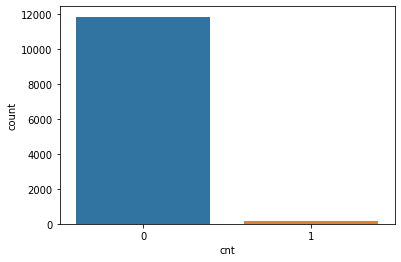

In [754]:
# Cantidad de registros (0: no outliers, 1: outliers)
sns.countplot(outl_s)

In [755]:
outl_s.value_counts()

0    11846
1      153
Name: cnt, dtype: int64

**Usaremos los resultados del análisis de tukey**, así que procedemos a crear la columna que que distingue los outlier encontrados el cual usaremos para un posterior análisis si se incluye o no en el entrenamiento del modelo

In [941]:
train_df['outlier'] = outl_q

In [942]:
train_df['outlier'].value_counts()

0    11623
1      376
Name: outlier, dtype: int64

#### Variables **predictoras**

> ***Visualización de features categóricos***

Asignacion del tipo de dato:

- season, workingday, weathersit, holiday, yr, mnth, hr, weekday: `Categóricos`

                         Visualización de features categóricos (train):                         


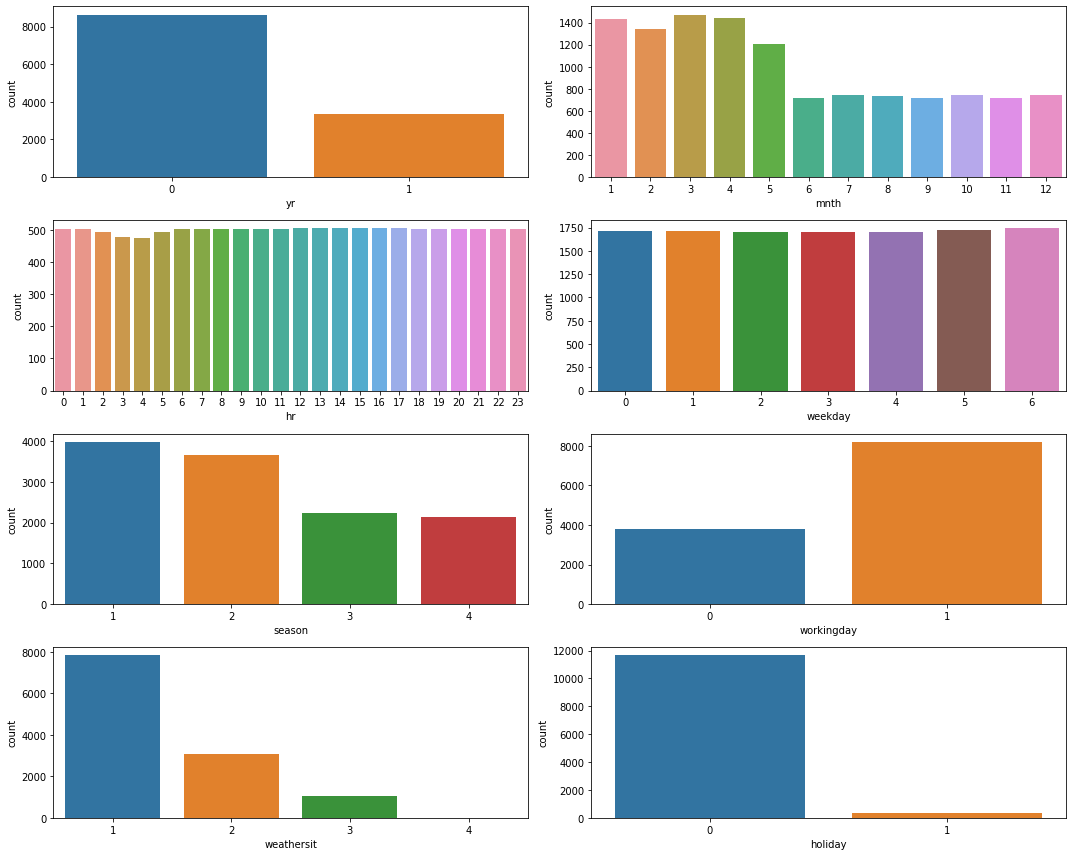

In [758]:
print('\033[1mVisualización de features categóricos (train):'.center(100))
cf = ["yr","mnth","hr","weekday","season", "workingday","weathersit","holiday"]
n = 2
plt.figure(figsize = [15,3*math.ceil(len(cf)/n)])

for i in range(len(cf)):
    if train_df[cf[i]].nunique() <= 6: # Cantidad de valores unicos de la serie df[cf[i]]
        plt.subplot(math.ceil(len(cf)/n), n, i+1)
        sns.countplot(train_df[cf[i]])
    else:
        plt.subplot(4, 2, i+1)
        sns.countplot(train_df[cf[i]])

plt.tight_layout()
plt.show()

**Nota:**  Para el entrenamiento, la columna_valor(weathersit_4) se descarta, solo se contará con solo 3 valores, así que se procederá a eliminar registros que contengan este valor, y además se logrará visualizar que en el conjunto de prueba este valor no existe

In [759]:
train_df.weathersit.value_counts()

1    7843
2    3095
3    1058
4       3
Name: weathersit, dtype: int64

In [760]:
train_df[train_df.weathersit == 4]

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,outlier
585,1,0,1,16,0,3,1,4,0.22,0.1970,0.93,0.3284,1,35,36,0
8854,1,1,1,18,0,1,1,4,0.20,0.2273,0.86,0.0896,6,158,164,0
9123,1,1,1,1,0,6,0,4,0.14,0.1364,0.86,0.1940,1,22,23,0


                         Visualización de features categóricos (test):                          


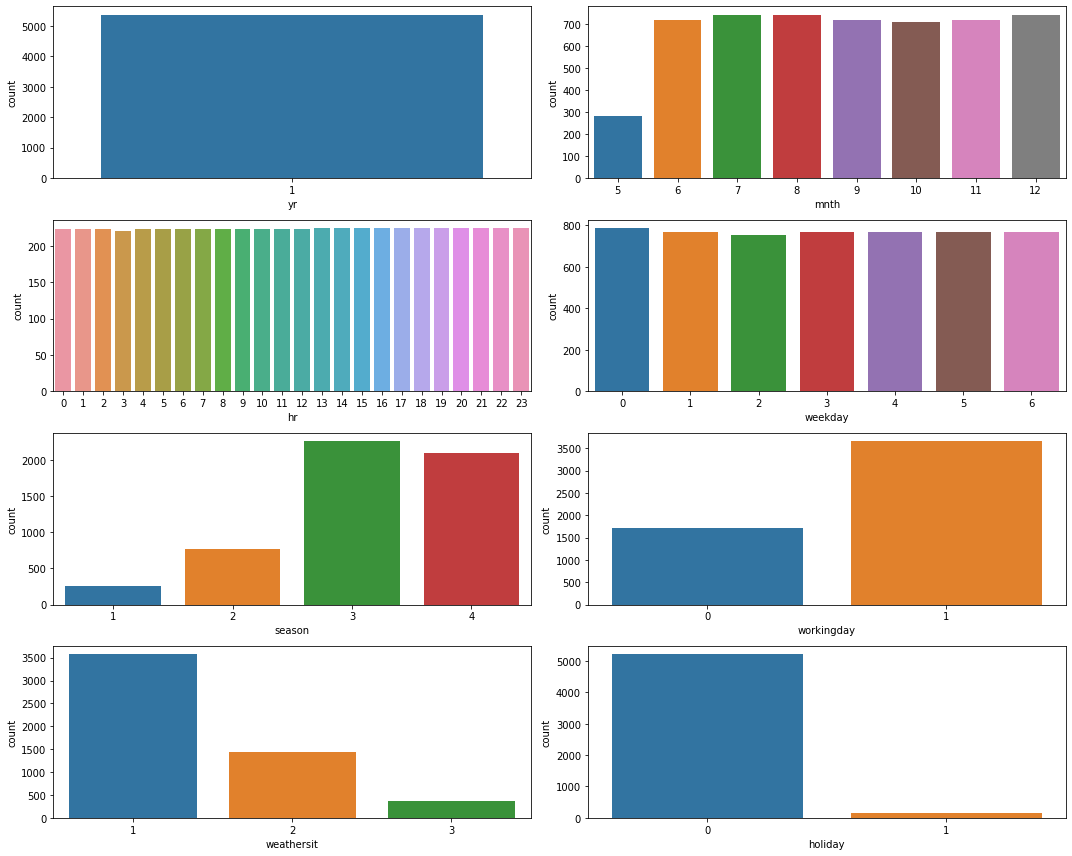

In [761]:
print('\033[1mVisualización de features categóricos (test):'.center(100))
cf = ["yr","mnth","hr","weekday","season", "workingday","weathersit","holiday"]
n = 2
plt.figure(figsize = [15,3*math.ceil(len(cf)/n)])

for i in range(len(cf)):
    if train_df[cf[i]].nunique() <= 6: # Cantidad de valores unicos de la serie df[cf[i]]
        plt.subplot(math.ceil(len(cf)/n), n, i+1)
        sns.countplot(test_df[cf[i]])
    else:
        plt.subplot(4, 2, i+1)
        sns.countplot(test_df[cf[i]])

plt.tight_layout()
plt.show()

**Nota:** En el conjunto de prueba, se cuenta con los siguientes datos:
- `mnth`: 5-12
- `wethersit`: 1-3

Resaltándose la falta de valores de mes del 1 al 4 y de wethersit 4

***Visualización de features numéricos***

                                          Distribución de features numéricos (train)                                          


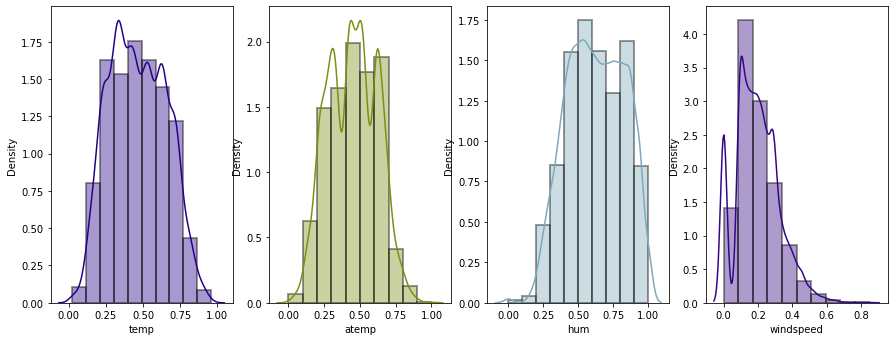

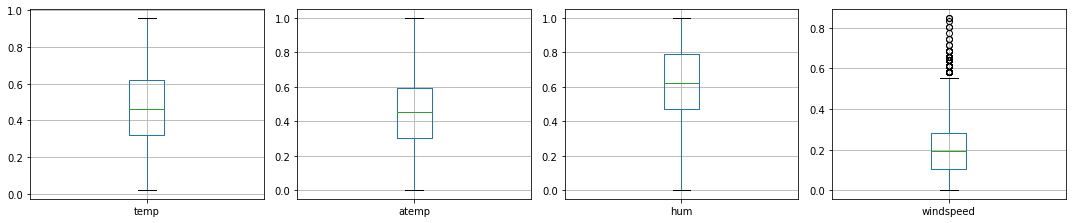

In [762]:
print('\033[1mDistribución de features numéricos (train)'.center(130))

n = 4
nf = ['temp', 'atemp', 'hum', 'windspeed']
clr = ['r', 'g', 'b', 'g', 'b', 'r']

plt.figure(figsize = [15, 6*math.ceil(len(cf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/2), n, i+1)
    sns.distplot(train_df[nf[i]], hist_kws = dict(edgecolor = 'black', linewidth = 2), 
               bins = 10, color = list(np.random.randint([255,255,255])/255))

plt.figure(figsize = [15, 6*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/2), n, i+1)
    train_df.boxplot(nf[i])

plt.tight_layout()
plt.show()

**Conclusiones:** 
- El feature `windspeed` cuenta con outliers, pero debido a su poder predictivo lineal será casi insignificante

In [ ]:
train_df.windspeed.count()

11999

In [943]:
cuart = pd.qcut(train_df.windspeed, q = [0,.25,.50,.75,1], retbins = True)[1]
Q1 = cuart[1]
Q2 = cuart[2]
Q3 = cuart[3]
IQR = Q3 - Q1
wind_q = train_df.windspeed.apply(lambda e: 1 if (e > Q3 + 1.5*IQR)|(e < Q1 - 1.5*IQR) else 0)

In [944]:
len(wind_q[wind_q == 1]) # 86 registros como outliers, procederemos a eliminar esos registros

86

In [945]:
train_df['outlier_wind'] = wind_q

In [946]:
train_df[train_df.outlier_wind == 1].head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,outlier,outlier_wind
265,1,0,1,12,0,3,1,1,0.20,0.1515,0.47,0.5821,3,52,55,0,1
467,1,0,1,12,0,5,1,1,0.22,0.1818,0.27,0.5821,11,67,78,0,1
468,1,0,1,13,0,5,1,1,0.20,0.1515,0.21,0.5821,8,65,73,0,1
870,1,0,2,17,0,2,1,1,0.22,0.1818,0.32,0.5821,4,172,176,0,1
1007,1,0,2,15,0,1,1,1,0.56,0.5303,0.21,0.6567,19,71,90,0,1


In [947]:
train_df = train_df[train_df['outlier_wind'] == 0]

In [948]:
train_df = train_df[train_df['weathersit'] <= 3]

In [949]:
train_df.shape

(11910, 17)

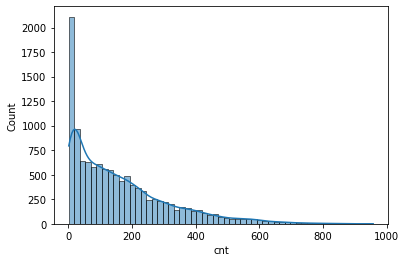

In [950]:
sns.histplot(train_df.cnt, kde=True)
plt.show()

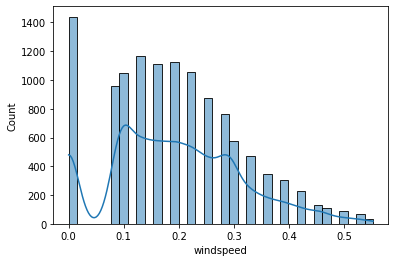

In [951]:
sns.histplot(train_df.windspeed, kde=True)
plt.show()

- Los features `temp`, `atemp`, `hum`, `windspeed` parecen seguir una distribución normal, lo corroboramos mediante un intervalo de -1 a 1, mediante ciertos estadísticos.

Los estadísticos de asimetría (Skewness) y curtosis pueden emplearse para detectar desviaciones de la normalidad. Un valor de curtosis y/o coeficiente de asimetría entre -1 y 1, es generalmente considerada una ligera desviación de la normalidad. Entre -2 y 2 hay una evidente desviación de la normal pero no extrema.

In [207]:
print('Kursotis:', stats.kurtosis(train_df['atemp']))
print('Skewness:', stats.skew(train_df['atemp']))

Kursotis: -0.7636265785266199
Skewness: 0.03132785107081779


In [208]:
print('Kursotis:', stats.kurtosis(train_df['temp']))
print('Skewness:', stats.skew(train_df['temp']))

Kursotis: -0.8491237019683897
Skewness: 0.11861365828411796


In [209]:
print('Kursotis:', stats.kurtosis(train_df['hum']))
print('Skewness:', stats.skew(train_df['hum']))

Kursotis: -0.8416828659063227
Skewness: -0.09782048774098204


In [210]:
print('Kursotis:', stats.kurtosis(train_df['windspeed']))
print('Skewness:', stats.skew(train_df['windspeed']))

Kursotis: -0.17505304608392036
Skewness: 0.35415746755827204


## 4. Feature engineering
<div id='id4'/>

<div id='idfeat'/>

Análisis previo de la matrix de correlación -> [link](#idconc)

### Selección de features con linear regression

In [953]:
train_prep_1 = train_df.drop(['casual','registered', 'outlier','outlier_wind'], axis = 1).copy()

In [954]:
train_prep_1.columns

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

In [955]:
X_reg = train_prep_1.drop(['cnt'], axis = 1)
y_reg = train_prep_1['cnt']

In [956]:
import statsmodels.api as sm
X_constant = sm.add_constant(X_reg)
lin_reg = sm.OLS(y_reg, X_constant).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     600.3
Date:                Thu, 15 Sep 2022   Prob (F-statistic):               0.00
Time:                        01:24:21   Log-Likelihood:                -73887.
No. Observations:               11910   AIC:                         1.478e+05
Df Residuals:                   11897   BIC:                         1.479e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -24.2364      7.121     -3.403      0.001     -38.195     -10.278
season        12.9009      2.071      6.230      0.000       8.842      16.960
yr            86.0051      2.832     30.374      0.000      80.455      91.555
mnth           1.6074      0.657      2.445      0.015       0.319       2.896
hr             6.5293      0.167     39.083      0.000       6.202       6.857
holiday      -22.0663      6.953     -3.174      0.002     -35.695      -8.438
weekday        1.6427      0.552      2.978      0.003       0.561       2.724
workingday    -0.8062      2.445     -0.330      0.742      -5.600       3.987
weathersit    -6.2150      1.921     -3.235      0.001      -9.981      -2.449
temp          37.8913     49.246      0.769      0.442     -58.639     134.422
atemp        270.2931     54.828      4.930      0.000     162.821     377.765
hum         -149.7766      6.806    -22.005      0.000    -163.118    -136.435
windspeed     31.4026     10.227      3.070      0.002      11.355      51.450
==============================================================================
Omnibus:                     2265.235   Durbin-Watson:                   0.559
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4314.155
Skew:                           1.171   Prob(JB):                         0.00
Kurtosis:                       4.791   Cond. No.                         998.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Conclusiones:**
- Las variables no significativas (>0.05) encontradas en el modelo son:
  * `temp`
  * `workingday`

### Selección de features con Recursive Feature Elimination

In [957]:
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators = 100)

selector = RFECV(model, step=3, min_features_to_select = 3, cv = 4)
selector.fit(X_reg, y_reg)

RFECV(cv=4,
      estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                             colsample_bylevel=None, colsample_bynode=None,
                             colsample_bytree=None, early_stopping_rounds=None,
                             enable_categorical=False, eval_metric=None,
                             gamma=None, gpu_id=None, grow_policy=None,
                             importance_type=None, interaction_constraints=None,
                             learning_rate=None, max_bin=None,
                             max_cat_to_onehot=None, max_delta_step=None,
                             max_depth=None, max_leaves=None,
                             min_child_weight=None, missing=nan,
                             monotone_constraints=None, n_estimators=100,
                             n_jobs=None, num_parallel_tree=None,
                             predictor=None, random_state=None, reg_alpha=None,
                             reg_lambda=None, 

In [958]:
print(X_reg.columns)
print(selector.ranking_)

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed'],
      dtype='object')
[2 1 3 1 2 2 1 1 1 1 3 3]


In [960]:
selector.grid_scores_.mean() # Todos parecen ser importantes

0.6060108038737072

**Conclusiones:**
- Las variables mas importantes son:
  * `yr`
  * `hr`
  * `workingday`
  * `weathersit`
  * `temp`
  * `atemp`
  
- Las variables menos importantes son:
  * `mnth`
  * `hum`
  * `windspeed`
  

### Selección de features con SlectKbest

In [961]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
selector = SelectKBest(mutual_info_regression, k=4)
selector.fit(X_reg,y_reg)
selector.scores_

array([0.05109386, 0.02331662, 0.06073182, 0.64526762, 0.        ,
       0.01704873, 0.02081512, 0.01321828, 0.1324596 , 0.14591479,
       0.09176209, 0.01740715])

In [962]:
X_reg.columns

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed'],
      dtype='object')

In [963]:
pd.DataFrame(selector.scores_.reshape(-1,1), index = X_reg.columns, columns = ['columns']).sort_values(by = ['columns'], axis = 0, ascending = False)

,columns
hr,0.645268
atemp,0.145915
temp,0.132460
hum,0.091762
mnth,0.060732
season,0.051094
yr,0.023317
workingday,0.020815
windspeed,0.017407
weekday,0.017049


## 5. Preprocesamiento de datos
<div id='id5'/>

In [968]:
train_df_prep_1 = train_df.drop(['outlier', 'outlier_wind','casual', 'registered'], axis = 1)
train_df_prep_1

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11994,2,1,5,23,0,6,0,1,0.60,0.6212,0.56,0.1642,239
11995,2,1,5,0,0,0,0,1,0.58,0.5455,0.53,0.1045,170
11996,2,1,5,1,0,0,0,1,0.56,0.5303,0.52,0.0000,130
11997,2,1,5,2,0,0,0,1,0.56,0.5303,0.52,0.0000,98


### 5.1. Guiándonos de la matriz de correlación lineal

<div id='idtrainfs1'/>

[Prep Prueba](#idpruebafs1)

Eliminamos `temp`, `mnth`, `weekday`, `holiday`, `windspeed`

In [1068]:
train_prep_fs_1 = train_df_prep_1.drop(['temp','mnth', 'weekday', 'holiday', 'windspeed'],axis = 1)

In [1069]:
train_prep_fs_1.columns

Index(['season', 'yr', 'hr', 'workingday', 'weathersit', 'atemp', 'hum',
       'cnt'],
      dtype='object')

#### División del conjuntos de datos, en train y validation

In [1070]:
train_prep_fs_1.head()

,season,yr,hr,workingday,weathersit,atemp,hum,cnt
0,1,0,0,0,1,0.2879,0.81,16
1,1,0,1,0,1,0.2727,0.80,40
2,1,0,2,0,1,0.2727,0.80,32
3,1,0,3,0,1,0.2879,0.75,13
4,1,0,4,0,1,0.2879,0.75,1


In [1071]:
# (nro. filas, nro. columnas)
train_prep_fs_1.shape

(11910, 8)

Se probará 85%(train) y 15%(test)

In [1072]:
X_1 = train_prep_fs_1.drop(['cnt'], axis = 1)
y_1 = train_prep_fs_1['cnt']

In [1073]:
train_X_1, val_X_1, train_y_1, val_y_1 = train_test_split(X_1, y_1, test_size=0.15, random_state = 2208)

### 5.2. Usando el 2do método de selección mediante regresión lineal

<div id='idtrainfs2'/>

[Prep Prueba](#idpruebafs2)

Eliminamos `mnth`,`temp` , tiene mayor efecto que eliminar por `season`

In [1074]:
train_prep_fs_2 = train_df_prep_1.drop(['temp','mnth'],axis = 1)

In [1075]:
train_prep_fs_2.columns

Index(['season', 'yr', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit',
       'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

#### División del conjuntos de datos, en train y validation

In [1076]:
train_prep_fs_2.head()

,season,yr,hr,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt
0,1,0,0,0,6,0,1,0.2879,0.81,0.0,16
1,1,0,1,0,6,0,1,0.2727,0.80,0.0,40
2,1,0,2,0,6,0,1,0.2727,0.80,0.0,32
3,1,0,3,0,6,0,1,0.2879,0.75,0.0,13
4,1,0,4,0,6,0,1,0.2879,0.75,0.0,1


In [1077]:
# (nro. filas, nro. columnas)
train_prep_fs_2.shape

(11910, 11)

Se probará 85% (train) y 15% (validación)

In [1078]:
X_2 = train_prep_fs_2.drop(['cnt'], axis = 1)
y_2 = train_prep_fs_2['cnt']

In [1079]:
train_X_2, val_X_2, train_y_2, val_y_2 = train_test_split(X_2, y_2, test_size=0.15, random_state = 2208)

### 5.3. Usando el 3er método de selección por RFECV

<div id='idtrainfs3'/>

[Prep Prueba](#idpruebafs3)

Eliminamos `mnth`,`hum`, `windspeed`, `temp`

In [1185]:
train_prep_fs_3 = train_df_prep_1.drop(['windspeed','hum','temp', 'mnth'],axis = 1)

In [1186]:
train_prep_fs_3.columns

Index(['season', 'yr', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit',
       'atemp', 'cnt'],
      dtype='object')

#### División del conjuntos de datos, en train y validation

In [1187]:
train_prep_fs_3.head()

,season,yr,hr,holiday,weekday,workingday,weathersit,atemp,cnt
0,1,0,0,0,6,0,1,0.2879,16
1,1,0,1,0,6,0,1,0.2727,40
2,1,0,2,0,6,0,1,0.2727,32
3,1,0,3,0,6,0,1,0.2879,13
4,1,0,4,0,6,0,1,0.2879,1


In [1188]:
# (nro. filas, nro. columnas)
train_prep_fs_3.shape

(11910, 9)

Se probará 85% (train) y 15% (validación)

In [1189]:
X_3 = train_prep_fs_3.drop(['cnt'], axis = 1)
y_3 = train_prep_fs_3['cnt']

In [1190]:
train_X_3, val_X_3, train_y_3, val_y_3 = train_test_split(X_3, y_3, test_size=0.15, random_state = 2208)

### 5.4. Usando el 4to SelectKbest

<div id='idtrainfs4'/>

[Prep Prueba](#idpruebafs4)

Eliminamos `windspeed`, `weekday`, `weathersit`, `holiday`, `workingday`

In [1276]:
train_prep_fs_4 = train_df_prep_1.drop(['weekday', 'holiday', 'weathersit'],axis = 1)

In [1277]:
train_prep_fs_4.columns

Index(['season', 'yr', 'mnth', 'hr', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'cnt'],
      dtype='object')

#### División del conjuntos de datos, en train y validation

In [1278]:
train_prep_fs_4.head()

,season,yr,mnth,hr,workingday,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,0,0.24,0.2879,0.81,0.0,16
1,1,0,1,1,0,0.22,0.2727,0.80,0.0,40
2,1,0,1,2,0,0.22,0.2727,0.80,0.0,32
3,1,0,1,3,0,0.24,0.2879,0.75,0.0,13
4,1,0,1,4,0,0.24,0.2879,0.75,0.0,1


In [1279]:
# (nro. filas, nro. columnas)
train_prep_fs_4.shape

(11910, 10)

Se probará 85% (train) y 15% (validación)

In [1280]:
X_4 = train_prep_fs_4.drop(['cnt'], axis = 1)
y_4 = train_prep_fs_4['cnt']

In [1281]:
train_X_4, val_X_4, train_y_4, val_y_4 = train_test_split(X_4, y_4, test_size=0.15, random_state = 2208)

## 6. Modelos de entrenamiento
<div id='id6'/>
Se probará Modelos de Bosques aleatorios, XGboost y Redes neuronales

### 6.1 Random Forest
<div id='id6.1'/>

In [1172]:
my_param_grid = {'n_estimators':[100, 150, 250, 300], 'max_features':['sqrt', 'log2'], 'max_depth':[20, 30, 40]}

#### 1r intento 
[Test](#idtest1-rf)
<div id='ident1-rf'/>

In [1173]:
rf_1 = GridSearchCV(estimator = RandomForestRegressor(), param_grid = my_param_grid, refit = True, verbose = 2, cv = 5, scoring = 'neg_root_mean_squared_error', n_jobs = -1)

In [1174]:
rf_1.fit(train_X_1, train_y_1)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [20, 30, 40],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 150, 250, 300]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [1175]:
rf_1.best_estimator_

RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=250)

In [1176]:
# Este es
rf_1.best_score_*(-1)

49.68195338428224

In [1177]:
# Este es
rf_pred_1 = rf_1.predict(val_X_1)
rf_pred_1

array([ 94.36      ,  95.638     , 180.07670151, ..., 527.8688    ,
        91.06693333, 111.53815385])

In [1178]:
predictions_rf_1 = pd.DataFrame(val_y_1.values.reshape(-1,1), columns=['true_val'])

In [1179]:
predictions_rf_1['predict_val'] = rf_pred_1.reshape(-1,1)

In [1180]:
predictions_rf_1

,true_val,predict_val
0,64,94.360000
1,98,95.638000
2,153,180.076702
3,161,153.236000
4,187,212.110955
...,...,...
1782,163,241.215940
1783,21,15.822667
1784,544,527.868800
1785,109,91.066933


In [1181]:
rmse_rf_1 = round(np.sqrt(mean_squared_error(predictions_rf_1['true_val'], predictions_rf_1['predict_val'])),4)
rmse_rf_1

47.9477

#### 2do intento 
[Test](#idtest2-rf)
<div id='ident2-rf'/>

In [1182]:
rf_2 = GridSearchCV(estimator = RandomForestRegressor(), param_grid = my_param_grid, refit = True, verbose = 2, cv = 5, scoring = 'neg_root_mean_squared_error', n_jobs = -1)

In [1183]:
rf_2.fit(train_X_2, train_y_2)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [20, 30, 40],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 150, 250, 300]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [1184]:
rf_2.best_estimator_

RandomForestRegressor(max_depth=30, max_features='sqrt', n_estimators=300)

In [1197]:
# Este es
rf_2.best_score_*(-1)

49.50574783233789

In [1198]:
# Este es
rf_pred_2 = rf_2.predict(val_X_2)
rf_pred_2

array([102.87666667,  91.95666667, 178.63527778, ..., 508.49      ,
        94.20333333, 121.75      ])

In [1199]:
predictions_rf_2 = pd.DataFrame(val_y_2.values.reshape(-1,1), columns=['true_val'])

In [1200]:
predictions_rf_2['predict_val'] = rf_pred_2.reshape(-1,1)

In [1201]:
predictions_rf_2

,true_val,predict_val
0,64,102.876667
1,98,91.956667
2,153,178.635278
3,161,156.336667
4,187,190.563333
...,...,...
1782,163,196.786667
1783,21,19.930000
1784,544,508.490000
1785,109,94.203333


In [1202]:
rmse_rf_2 = round(np.sqrt(mean_squared_error(predictions_rf_2['true_val'], predictions_rf_2['predict_val'])),4)
rmse_rf_2

45.4738

#### 3er intento 
[Test](#idtest2-rf)
<div id='ident2-rf'/>

In [1203]:
rf_3 = GridSearchCV(estimator = RandomForestRegressor(), param_grid = my_param_grid, refit = True, verbose = 2, cv = 5, scoring = 'neg_root_mean_squared_error', n_jobs = -1)

In [1204]:
rf_3.fit(train_X_3, train_y_3)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [20, 30, 40],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 150, 250, 300]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [1205]:
rf_3.best_estimator_

RandomForestRegressor(max_depth=30, max_features='log2', n_estimators=300)

In [1206]:
# Este es
rf_3.best_score_*(-1)

43.65618699390708

In [1207]:
# Este es
rf_pred_3 = rf_3.predict(val_X_3)
rf_pred_3

array([101.19388889,  93.00666667, 170.16083333, ..., 531.7945    ,
       105.06055556, 124.92055556])

In [1208]:
predictions_rf_3 = pd.DataFrame(val_y_3.values.reshape(-1,1), columns=['true_val'])

In [1209]:
predictions_rf_3['predict_val'] = rf_pred_3.reshape(-1,1)

In [1210]:
predictions_rf_3

,true_val,predict_val
0,64,101.193889
1,98,93.006667
2,153,170.160833
3,161,146.252222
4,187,182.592333
...,...,...
1782,163,194.610000
1783,21,18.683333
1784,544,531.794500
1785,109,105.060556


In [1211]:
rmse_rf_3 = round(np.sqrt(mean_squared_error(predictions_rf_3['true_val'], predictions_rf_3['predict_val'])),4)
rmse_rf_3

40.211

#### 4to intento 
[Test](#idtest2-rf)
<div id='ident2-rf'/>

In [1370]:
rf_4 = GridSearchCV(estimator = RandomForestRegressor(), param_grid = my_param_grid, refit = True, verbose = 2, cv = 5, scoring = 'neg_root_mean_squared_error', n_jobs = -1)

In [1371]:
rf_4.fit(train_X_4, train_y_4)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [20, 30, 40],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 150, 250, 300]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [1372]:
rf_4.best_estimator_

RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=250)

In [1373]:
# Este es
rf_4.best_score_*(-1)

52.07563529497048

In [1374]:
# Este es
rf_pred_4 = rf_4.predict(val_X_4)
rf_pred_4

array([106.832     ,  92.0592    , 197.79321535, ..., 502.488     ,
        91.156     , 122.23533333])

In [1375]:
predictions_rf_4 = pd.DataFrame(val_y_4.values.reshape(-1,1), columns=['true_val'])

In [1376]:
predictions_rf_4['predict_val'] = rf_pred_4.reshape(-1,1)

In [1377]:
predictions_rf_4

,true_val,predict_val
0,64,106.832000
1,98,92.059200
2,153,197.793215
3,161,160.349514
4,187,207.842272
...,...,...
1782,163,234.651080
1783,21,20.901333
1784,544,502.488000
1785,109,91.156000


In [1378]:
rmse_rf_4 = round(np.sqrt(mean_squared_error(predictions_rf_4['true_val'], predictions_rf_4['predict_val'])),4)
rmse_rf_4

51.357

### 6.2 XGBoost
<div id='id6.2'/>

In [1291]:
parameters = {'n_estimators': [80, 100, 150, 200], 'max_depth': [10,20], 'learning_rate': [0.01, 0.03, 0.05]}

#### 1er intento 
[Test](#idtest1-xg)
<div id='ident1-xg'/>

In [1292]:
xg_1 = GridSearchCV(estimator = xgb.XGBRegressor(), param_grid = parameters, refit = True, scoring = 'neg_root_mean_squared_error', cv = 5, verbose = 2, n_jobs = -1)
xg_1.fit(train_X_1, train_y_1)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                  

In [1293]:
xg_1.best_params_

{'learning_rate': 0.03, 'max_depth': 10, 'n_estimators': 150}

In [1294]:
xg_1.best_score_*(-1)

42.65382019386786

In [1295]:
# Este es
xg_pred_1 = xg_1.predict(val_X_1)
xg_pred_1

array([ 79.996605,  93.283806, 167.46344 , ..., 504.5079  , 114.706375,
        89.75744 ], dtype=float32)

In [1296]:
predictions_xg_1 = pd.DataFrame(val_y_1.values.reshape(-1,1), columns=['true_val'])

In [1297]:
predictions_xg_1['predict_val'] = xg_pred_1.reshape(-1,1)

In [1298]:
predictions_xg_1

,true_val,predict_val
0,64,79.996605
1,98,93.283806
2,153,167.463440
3,161,159.596466
4,187,206.010681
...,...,...
1782,163,299.355927
1783,21,17.612598
1784,544,504.507904
1785,109,114.706375


In [1299]:
rmse_xg_1 = round(np.sqrt(mean_squared_error(predictions_xg_1['true_val'], predictions_xg_1['predict_val'])),4)
rmse_xg_1

40.4892

#### 2do intento 
[Test](#idtest2-xg)
<div id='ident2-xg'/>

In [1300]:
xg_2 = GridSearchCV(estimator = xgb.XGBRegressor(), param_grid = parameters, refit = True, scoring = 'neg_root_mean_squared_error', cv = 5, verbose = 2, n_jobs = -1)
xg_2.fit(train_X_2, train_y_2)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                  

In [1301]:
xg_2.best_params_

{'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 150}

In [1302]:
xg_2.best_score_*(-1)

37.75042258885242

In [1303]:
# Este es
xg_pred_2 = xg_2.predict(val_X_2)
xg_pred_2

array([ 94.22867 , 100.88706 , 164.57477 , ..., 495.19836 , 118.708305,
        88.21764 ], dtype=float32)

In [1304]:
predictions_xg_2 = pd.DataFrame(val_y_2.values.reshape(-1,1), columns=['true_val'])

In [1305]:
predictions_xg_2['predict_val'] = xg_pred_2.reshape(-1,1)

In [1306]:
predictions_xg_2

,true_val,predict_val
0,64,94.228668
1,98,100.887062
2,153,164.574768
3,161,145.070740
4,187,199.551758
...,...,...
1782,163,201.522232
1783,21,17.677114
1784,544,495.198364
1785,109,118.708305


In [1307]:
rmse_xg_2 = round(np.sqrt(mean_squared_error(predictions_xg_2['true_val'], predictions_xg_2['predict_val'])),4)
rmse_xg_2

32.9362

#### 3er intento 
[Test](#idtest2-xg)
<div id='ident2-xg'/>

In [1308]:
xg_3 = GridSearchCV(estimator = xgb.XGBRegressor(), param_grid = parameters, refit = True, scoring = 'neg_root_mean_squared_error', cv = 5, verbose = 2)
xg_3.fit(train_X_3, train_y_3)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ..learning_rate=0.01, max_depth=10, n_estimators=80; total time=   2.8s
[CV] END ..learning_rate=0.01, max_depth=10, n_estimators=80; total time=   1.6s
[CV] END ..learning_rate=0.01, max_depth=10, n_estimators=80; total time=   2.0s
[CV] END ..learning_rate=0.01, max_depth=10, n_estimators=80; total time=   1.6s
[CV] END ..learning_rate=0.01, max_depth=10, n_estimators=80; total time=   1.5s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=100; total time=   1.9s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=100; total time=   1.9s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=100; total time=   1.7s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=100; total time=   2.5s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=100; total time=   2.0s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=150; total time=   2.8s
[CV] END .learning_rate=0.01, max_depth=10, n_e

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                  

In [1309]:
xg_3.best_params_

{'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100}

In [1310]:
xg_3.best_score_*(-1)

40.68238596581855

In [1311]:
# Este es
xg_pred_3 = xg_3.predict(val_X_3)
xg_pred_3

array([101.7146  ,  96.777115, 173.03542 , ..., 498.17355 , 117.82959 ,
       113.80219 ], dtype=float32)

In [1312]:
predictions_xg_3 = pd.DataFrame(val_y_3.values.reshape(-1,1), columns=['true_val'])

In [1313]:
predictions_xg_3['predict_val'] = xg_pred_3.reshape(-1,1)

In [1314]:
predictions_xg_3

,true_val,predict_val
0,64,101.714600
1,98,96.777115
2,153,173.035416
3,161,125.827621
4,187,193.051529
...,...,...
1782,163,200.800751
1783,21,18.654148
1784,544,498.173553
1785,109,117.829590


In [1315]:
rmse_xg_3 = round(np.sqrt(mean_squared_error(predictions_xg_3['true_val'], predictions_xg_3['predict_val'])),4)
rmse_xg_3

37.1001

#### 4to intento 
[Test](#idtest2-xg)
<div id='ident2-xg'/>

In [ ]:
xg_4 = GridSearchCV(estimator = xgb.XGBRegressor(), param_grid = parameters, refit = True, scoring = 'neg_root_mean_squared_error', cv = 5, verbose = 2, n_jobs = -1)
xg_4.fit(train_X_4, train_y_4)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [ ]:
xg_4.best_params_

In [ ]:
xg_4.best_score_*(-1)

In [ ]:
# Este es
xg_pred_4 = xg_4.predict(val_X_4)
xg_pred_4

In [ ]:
predictions_xg_4 = pd.DataFrame(val_y_4.values.reshape(-1,1), columns=['true_val'])

In [ ]:
predictions_xg_4['predict_val'] = xg_pred_4.reshape(-1,1)

In [ ]:
predictions_xg_4

In [ ]:
rmse_xg_4 = round(np.sqrt(mean_squared_error(predictions_xg_4['true_val'], predictions_xg_4['predict_val'])),4)
rmse_xg_4

## 7. Pruebas
<div id='id7'/>

In [1324]:
test_prep_1 = test_df.drop(['instant', 'dteday'], axis = 1)

In [1325]:
test_prep_1.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,2,1,5,4,0,0,0,1,0.52,0.5000,0.68,0.0896
1,2,1,5,5,0,0,0,1,0.50,0.4848,0.72,0.1045
2,2,1,5,6,0,0,0,1,0.50,0.4848,0.63,0.1343
3,2,1,5,7,0,0,0,1,0.52,0.5000,0.68,0.1940
4,2,1,5,8,0,0,0,1,0.56,0.5303,0.56,0.1642


### Preprocesamiento test [Método de selección 1](#idtrainfs1)
<div id='idpruebafs1'/>

In [1326]:
test_prep_fs_1 = test_prep_1.drop(['temp','mnth', 'weekday', 'holiday', 'windspeed'],axis = 1)

In [1327]:
test_prep_fs_1.head()

,season,yr,hr,workingday,weathersit,atemp,hum
0,2,1,4,0,1,0.5000,0.68
1,2,1,5,0,1,0.4848,0.72
2,2,1,6,0,1,0.4848,0.63
3,2,1,7,0,1,0.5000,0.68
4,2,1,8,0,1,0.5303,0.56


[Entrenamiento RF](#ident1-rf)
<div id='idtest1-rf'/>

In [1328]:
test_rf_1 = rf_1.predict(test_prep_fs_1)

In [1329]:
test_rf_1 = np.round(test_rf_1.reshape(-1,1), 2)
test_rf_1

array([[ 14.49],
       [ 15.84],
       [ 25.38],
       ...,
       [102.01],
       [ 98.59],
       [ 62.84]])

In [1330]:
prueba_rf_1 = pd.DataFrame(test_rf_1, columns = ['pred'])

In [1331]:
prueba_rf_1

,pred
0,14.49
1,15.84
2,25.38
3,109.52
4,216.94
...,...
5375,203.56
5376,153.38
5377,102.01
5378,98.59


<AxesSubplot:ylabel='Count'>

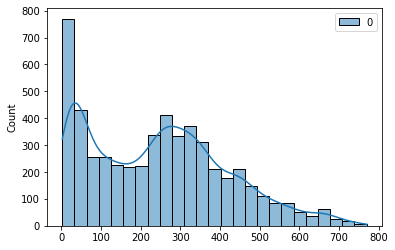

In [1332]:
sns.histplot(test_rf_1, kde=True)

In [864]:
prueba_rf_1.to_csv('Day 4/Sandtw_fs1_rf.csv', header=True, index=False)

[Entrenamiento XGB](#ident1-xg)
<div id='idtest1-xg'/>

In [1333]:
test_xg_1 = xg_1.predict(test_prep_fs_1)

In [1334]:
test_xg_1 = test_xg_1.reshape(-1,1)
test_xg_1

array([[ 10.824723],
       [  9.307249],
       [ 15.814681],
       ...,
       [106.19865 ],
       [100.17595 ],
       [ 55.831093]], dtype=float32)

In [1335]:
prueba_xg_1 = pd.DataFrame(test_xg_1, columns = ['pred'])

In [1336]:
prueba_xg_1

,pred
0,10.824723
1,9.307249
2,15.814681
3,67.109428
4,177.779236
...,...
5375,228.107864
5376,148.368027
5377,106.198647
5378,100.175949


<AxesSubplot:ylabel='Count'>

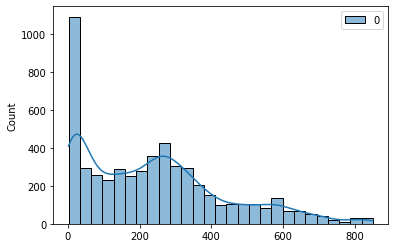

In [1337]:
sns.histplot(test_xg_1, kde=True)

In [289]:
prueba_xg_1.to_csv('Day 3/Sandtw.csv', header=True, index=False)

### Preprocesamiento test [Método de selección 2](#idtrainfs2)
<div id='idpruebafs2'/>

In [1338]:
test_prep_fs_2 = test_prep_1.drop(['temp','mnth'],axis = 1)

In [1339]:
test_prep_fs_2.head()

,season,yr,hr,holiday,weekday,workingday,weathersit,atemp,hum,windspeed
0,2,1,4,0,0,0,1,0.5000,0.68,0.0896
1,2,1,5,0,0,0,1,0.4848,0.72,0.1045
2,2,1,6,0,0,0,1,0.4848,0.63,0.1343
3,2,1,7,0,0,0,1,0.5000,0.68,0.1940
4,2,1,8,0,0,0,1,0.5303,0.56,0.1642


[Entrenamiento RF](#ident1-rf)
<div id='idtest1-rf'/>

In [1340]:
test_rf_2 = rf_2.predict(test_prep_fs_2)

In [1341]:
test_rf_2 = np.round(test_rf_2.reshape(-1,1))
test_rf_2

array([[ 22.],
       [ 18.],
       [ 24.],
       ...,
       [110.],
       [ 97.],
       [ 58.]])

In [1342]:
prueba_rf_2 = pd.DataFrame(test_rf_2, columns = ['pred'])

In [1343]:
prueba_rf_2

,pred
0,22.0
1,18.0
2,24.0
3,138.0
4,210.0
...,...
5375,197.0
5376,160.0
5377,110.0
5378,97.0


<AxesSubplot:ylabel='Count'>

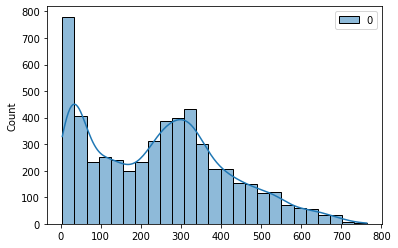

In [1344]:
sns.histplot(test_rf_2, kde=True)

In [937]:
prueba_rf_2.to_csv('Day 4/Sandtw_fs2_rf.csv', header=True, index=False)

[Entrenamiento XGB](#ident1-xg)
<div id='idtest1-xg'/>

In [1345]:
test_xg_2 = xg_2.predict(test_prep_fs_2)

In [1346]:
test_xg_2 = test_xg_2.reshape(-1,1)
test_xg_2

array([[ 14.395544],
       [ 12.969662],
       [ 19.645744],
       ...,
       [115.438194],
       [ 94.36721 ],
       [ 39.973698]], dtype=float32)

In [1347]:
prueba_xg_2 = pd.DataFrame(test_xg_2, columns = ['pred'])

In [1348]:
prueba_xg_2

,pred
0,14.395544
1,12.969662
2,19.645744
3,60.101242
4,158.453964
...,...
5375,239.083267
5376,155.603516
5377,115.438194
5378,94.367210


<AxesSubplot:ylabel='Count'>

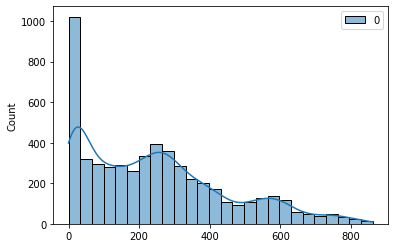

In [1349]:
sns.histplot(test_xg_2, kde=True)

In [1350]:
prueba_xg_2.to_csv('Day 4/Sandtw.csv', header=True, index=False)

### Preprocesamiento test [Método de selección 3](#idtrainfs3)
<div id='idpruebafs2'/>

In [1351]:
test_prep_fs_3 = test_prep_1.drop(['windspeed','hum','temp', 'mnth'],axis = 1)

In [1352]:
test_prep_fs_3.head()

,season,yr,hr,holiday,weekday,workingday,weathersit,atemp
0,2,1,4,0,0,0,1,0.5000
1,2,1,5,0,0,0,1,0.4848
2,2,1,6,0,0,0,1,0.4848
3,2,1,7,0,0,0,1,0.5000
4,2,1,8,0,0,0,1,0.5303


[Entrenamiento RF](#ident1-rf)
<div id='idtest1-rf'/>

In [1353]:
test_rf_3 = rf_3.predict(test_prep_fs_3)

In [1354]:
test_rf_3 = np.round(test_rf_3.reshape(-1,1))
test_rf_3

array([[ 20.],
       [ 14.],
       [ 21.],
       ...,
       [118.],
       [ 97.],
       [ 55.]])

In [1355]:
prueba_rf_3 = pd.DataFrame(test_rf_3, columns = ['pred'])

In [1356]:
prueba_rf_3

,pred
0,20.0
1,14.0
2,21.0
3,80.0
4,171.0
...,...
5375,224.0
5376,165.0
5377,118.0
5378,97.0


<AxesSubplot:ylabel='Count'>

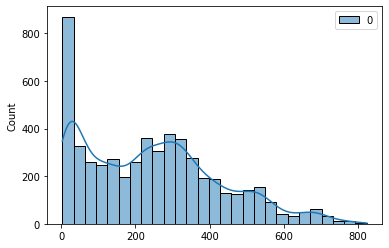

In [1357]:
sns.histplot(test_rf_3, kde=True)

In [937]:
prueba_rf_3.to_csv('Day 4/Sandtw_fs2_rf.csv', header=True, index=False)

[Entrenamiento XGB](#ident1-xg)
<div id='idtest1-xg'/>

In [1358]:
test_xg_3 = xg_3.predict(test_prep_fs_3)

In [1359]:
test_xg_3 = test_xg_3.reshape(-1,1)
test_xg_3

array([[ 12.6913595],
       [  9.952255 ],
       [ 18.083084 ],
       ...,
       [106.46093  ],
       [ 97.35584  ],
       [ 42.59365  ]], dtype=float32)

In [1360]:
prueba_xg_3 = pd.DataFrame(test_xg_3, columns = ['pred'])

In [1361]:
prueba_xg_3

,pred
0,12.691360
1,9.952255
2,18.083084
3,57.837334
4,151.343506
...,...
5375,221.695602
5376,150.520981
5377,106.460930
5378,97.355843


<AxesSubplot:ylabel='Count'>

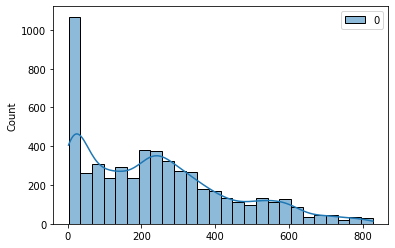

In [1362]:
sns.histplot(test_xg_3, kde=True)

In [289]:
prueba_xg_3.to_csv('Day 4/Sandtw.csv', header=True, index=False)

### Preprocesamiento test [Método de selección 4](#idtrainfs4)
<div id='idpruebafs2'/>

In [1367]:
test_prep_fs_4 = test_prep_1.drop(['windspeed','weekday','weathersit', 'holiday'],axis = 1)

In [1368]:
test_prep_fs_4.head()

,season,yr,mnth,hr,workingday,temp,atemp,hum
0,2,1,5,4,0,0.52,0.5000,0.68
1,2,1,5,5,0,0.50,0.4848,0.72
2,2,1,5,6,0,0.50,0.4848,0.63
3,2,1,5,7,0,0.52,0.5000,0.68
4,2,1,5,8,0,0.56,0.5303,0.56


[Entrenamiento RF](#ident1-rf)
<div id='idtest1-rf'/>

In [1369]:
test_rf_4 = rf_4.predict(test_prep_fs_4)

ValueError: X has 8 features, but DecisionTreeRegressor is expecting 9 features as input.

In [1366]:
test_rf_4 = np.round(test_rf_4.reshape(-1,1))
test_rf_4

NameError: name 'test_rf_4' is not defined

In [934]:
prueba_rf_4 = pd.DataFrame(test_rf_4, columns = ['pred'])

In [935]:
prueba_rf_4

,pred
0,25.0
1,27.0
2,22.0
3,127.0
4,201.0
...,...
5375,183.0
5376,152.0
5377,107.0
5378,104.0


<AxesSubplot:ylabel='Count'>

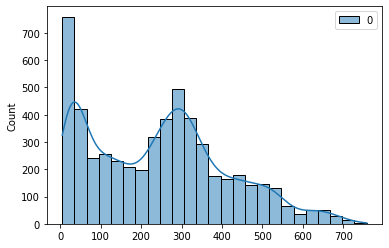

In [936]:
sns.histplot(test_rf_4, kde=True)

In [937]:
prueba_rf_4.to_csv('Day 4/Sandtw_fs2_rf.csv', header=True, index=False)

[Entrenamiento XGB](#ident1-xg)
<div id='idtest1-xg'/>

In [284]:
test_xg_4 = xg_4.predict(test_prep_fs_4)

In [285]:
test_xg_4 = test_xg_4.reshape(-1,1)
test_xg_4

array([[ 16.082905],
       [  9.606393],
       [ 19.27836 ],
       ...,
       [119.077354],
       [ 95.67325 ],
       [ 42.89646 ]], dtype=float32)

In [286]:
prueba_xg_4 = pd.DataFrame(test_xg_4, columns = ['pred'])

In [287]:
prueba_xg_4

,pred
0,16.082905
1,9.606393
2,19.278360
3,61.922333
4,166.994781
...,...
5375,244.035721
5376,155.692490
5377,119.077354
5378,95.673248


<AxesSubplot:ylabel='Count'>

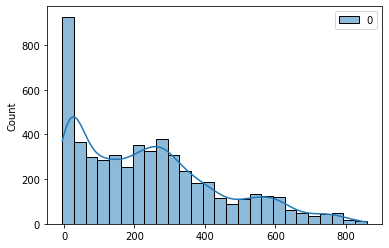

In [288]:
sns.histplot(test_xg_4, kde=True)

In [289]:
prueba_xg_4.to_csv('Day 4/Sandtw.csv', header=True, index=False)

# Probando forecast

In [581]:
train_df_forecast = pd.read_excel('Dataset/bike_train.xlsx')
test_df_forecast = pd.read_excel('Dataset/bike_test_act.xlsx')

In [568]:
from datetime import datetime
date_object = datetime.strptime('4', "%H").time()
date_object

datetime.time(4, 0)

In [582]:
train_df_forecast['hr'] = train_df_forecast['hr'].apply(lambda x: datetime.strptime(str(x), "%H").time())

In [583]:
train_df_forecast

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,00:00:00,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,01:00:00,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,02:00:00,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,03:00:00,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,04:00:00,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11994,11995,2012-05-19,2,1,5,23:00:00,0,6,0,1,0.60,0.6212,0.56,0.1642,71,168,239
11995,11996,2012-05-20,2,1,5,00:00:00,0,0,0,1,0.58,0.5455,0.53,0.1045,42,128,170
11996,11997,2012-05-20,2,1,5,01:00:00,0,0,0,1,0.56,0.5303,0.52,0.0000,28,102,130
11997,11998,2012-05-20,2,1,5,02:00:00,0,0,0,1,0.56,0.5303,0.52,0.0000,36,62,98


In [587]:
train_df_forecast['datetime'] = pd.to_datetime(train_df_forecast['dteday'].astype('str') + ' ' + train_df_forecast['hr'].astype('str'))

In [588]:
train_df_forecast

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,datetime
0,1,2011-01-01,1,0,1,00:00:00,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16,2011-01-01 00:00:00
1,2,2011-01-01,1,0,1,01:00:00,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40,2011-01-01 01:00:00
2,3,2011-01-01,1,0,1,02:00:00,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32,2011-01-01 02:00:00
3,4,2011-01-01,1,0,1,03:00:00,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13,2011-01-01 03:00:00
4,5,2011-01-01,1,0,1,04:00:00,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1,2011-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11994,11995,2012-05-19,2,1,5,23:00:00,0,6,0,1,0.60,0.6212,0.56,0.1642,71,168,239,2012-05-19 23:00:00
11995,11996,2012-05-20,2,1,5,00:00:00,0,0,0,1,0.58,0.5455,0.53,0.1045,42,128,170,2012-05-20 00:00:00
11996,11997,2012-05-20,2,1,5,01:00:00,0,0,0,1,0.56,0.5303,0.52,0.0000,28,102,130,2012-05-20 01:00:00
11997,11998,2012-05-20,2,1,5,02:00:00,0,0,0,1,0.56,0.5303,0.52,0.0000,36,62,98,2012-05-20 02:00:00


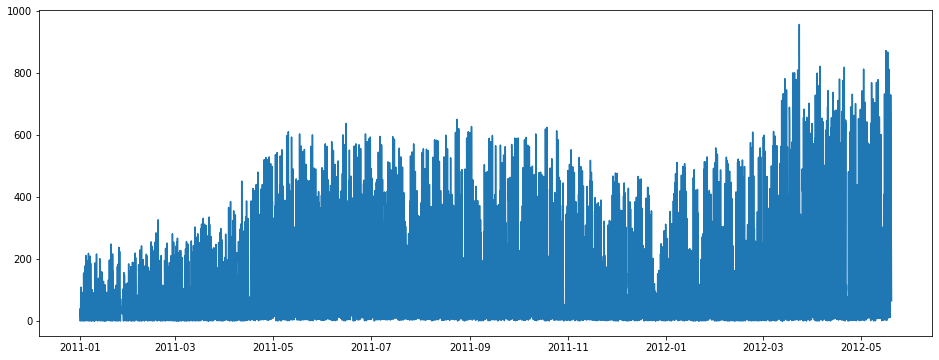

In [598]:
plt.figure(figsize = (16, 6))
plt.plot(train_df_forecast['datetime'], train_df_forecast['cnt'])

In [600]:
train_df_forecast.groupby(['dteday', 'weekday'])['hr'].count().head(50)

dteday      weekday
2011-01-01  6          24
2011-01-02  0          23
2011-01-03  1          22
2011-01-04  2          23
2011-01-05  3          23
2011-01-06  4          23
2011-01-07  5          23
2011-01-08  6          24
2011-01-09  0          24
2011-01-10  1          24
2011-01-11  2          22
2011-01-12  3          22
2011-01-13  4          24
2011-01-14  5          23
2011-01-15  6          24
2011-01-16  0          24
2011-01-17  1          24
2011-01-18  2          12
2011-01-19  3          23
2011-01-20  4          24
2011-01-21  5          24
2011-01-22  6          23
2011-01-23  0          23
2011-01-24  1          23
2011-01-25  2          23
2011-01-26  3          16
2011-01-27  4           8
2011-01-28  5          23
2011-01-29  6          23
2011-01-30  0          23
2011-01-31  1          24
2011-02-01  2          23
2011-02-02  3          24
2011-02-03  4          23
2011-02-04  5          23
2011-02-05  6          24
2011-02-06  0          24
2011-02-07  1     

In [ ]:
train_df_forecast.groupby(['dteday', 'weekday'])['hr'].count().head(50)